# Experiments in Camera Alignment Using Image Encoding Comparisons

This notebook compiles a set of experiments in selecting the frame from an exploratory scan that best matches a fixed set of example target frames. In practice, the target frames are extracted from the beginnings of RUM training data, and aligning the camera to the best scan frame match should give the best possibility of RUM policy execution success.

In [1]:
import os

import torch
import typing
from tqdm import tqdm

import video
import encoders
import visualizations

import torch.nn.functional as F

In [5]:
# from pathlib import Path
# import torchvision.transforms as transforms
# 
# dataset_path = 'C:/Users/clack/Datasets/Bag_Task_Data/bag_pick_up'
# video_paths = [file for file in Path(dataset_path).rglob('*.mp4') if 'Depth' not in str(file.name)]
# depth_paths = [next(Path(os.path.dirname(path)).rglob('*.bin')) for path in video_paths]
# video_scan_path = '../scans/scan-over-bag-kitchen/rgb_frames.mp4'
# depth_scan_path = '../scans/scan-over-bag-kitchen/depth_frames'
# 
# rgb_start_frames_cache_path = '../cache/bag_pickup/rgb_start_frames.pt'
# depth_start_frames_cache_path = '../cache/bag_pickup/depth_start_frames.pt'
# rgb_scan_frames_cache_path = '../cache/bag_pickup/rgb_scan_frames.pt'
# depth_scan_frames_cache_path = '../cache/bag_pickup/depth_scan_frames.pt'
# 
# rgb_start_frames = video.load_start_frames(video_paths, cache_path=rgb_start_frames_cache_path)
# rgb_scan_frames = video.load_video_frames(video_scan_path, cache_path=rgb_scan_frames_cache_path)
# depth_scan_frames = video.depth_to_rgb(video.load_depth_frames_from_individual_binaries(depth_scan_path, cache_path=depth_scan_frames_cache_path), resize=(256, 256))
# depth_start_frames = video.depth_to_rgb(video.load_depth_start_frames(depth_paths, cache_path=depth_start_frames_cache_path), resize=(256, 256))
# 
# alignment_scores = compute_alignment_scores(
#     rgb_scan_frames,
#     rgb_start_frames,
#     encoders.resnet_encoder('cuda'),
#     aver,
#     # scan_frame_encodings_cache_path='../cache/scan_frame_encodings.pt',
#     # target_frame_encodings_cache_path='../cache/start_frame_encodings.pt'
# )
# 
# visualizations.display_alignment_scores(alignment_scores)
# visualizations.display_most_aligned_frames(scan_frames, alignment_scores, top_k=20)

torch.Size([606, 3, 256, 256]) torch.Size([606, 3, 256, 256]) torch.Size([506, 3, 256, 256]) torch.Size([506, 3, 256, 256])


In [7]:
def average_cosine_similarity(frame_encoding: torch.Tensor, start_frame_encodings: torch.Tensor) -> float:
    """
    Computes the average cosine similarity between one encoding against a set of encodings.
    :param frame_encoding: An encoding of shape (D)
    :param start_frame_encodings: A set of encodings of shape (B x D)
    :return: 
    """
    x, y = start_frame_encodings, frame_encoding.unsqueeze(0).expand(start_frame_encodings.size(0), -1)
    similarity = F.cosine_similarity(x, y, dim=-1)
    return similarity.mean().item()

def softmax_cosine_similarity(frame_encoding: torch.Tensor, start_frame_encodings: torch.Tensor) -> float:
    x, y = start_frame_encodings, frame_encoding.unsqueeze(0).expand(start_frame_encodings.size(0), -1)
    similarity = F.cosine_similarity(x, y, dim=-1)
    return (similarity.softmax(0) * similarity).mean().item()

def max_cosine_similarity(frame_encoding: torch.Tensor, start_frame_encodings: torch.Tensor) -> float:
    x, y = start_frame_encodings, frame_encoding.unsqueeze(0).expand(start_frame_encodings.size(0), -1)
    similarity = F.cosine_similarity(x, y, dim=-1)
    return similarity.max().item()

def cosine_similarity_to_average(frame_encoding: torch.Tensor, start_frame_encodings: torch.Tensor) -> float:
    average_start_frame_encoding = start_frame_encodings.mean(dim=0)
    return F.cosine_similarity(frame_encoding.unsqueeze(0), average_start_frame_encoding, dim=-1).item()

def average_negative_squared_l2_norm(frame_encoding: torch.Tensor, start_frame_encodings: torch.Tensor) -> float:
    x, y = start_frame_encodings, frame_encoding.unsqueeze(0).expand(start_frame_encodings.size(0), -1)
    norm = torch.norm(x - y, dim=-1)
    return -norm.mean().item()

In [8]:
def compute_alignment_scores(
    scan_frames: torch.Tensor,
    target_frames: torch.Tensor,
    encoder: typing.Callable[[torch.Tensor], torch.Tensor],
    compute_encoding_alignment_score: typing.Callable[[torch.Tensor, torch.Tensor], float],
    scan_frame_encodings_cache_path: str = None,
    target_frame_encodings_cache_path: str = None
):
    scan_frame_encodings = video.encode_frames(
        encoder,
        scan_frames,
        cache_path=scan_frame_encodings_cache_path,
        batch_size=32
    )
    target_frame_encodings = video.encode_frames(
        encoder,
        target_frames,
        cache_path=target_frame_encodings_cache_path,
        batch_size=32
    )

    alignment_scores = []
    for scan_frame in tqdm(scan_frame_encodings, desc='Comparing each scan frame to start frames'):
        alignment_scores.append(compute_encoding_alignment_score(scan_frame, target_frame_encodings))

    return alignment_scores

In [9]:
def run_experiment(
        encoder: typing.Callable[[torch.Tensor], torch.Tensor],
        similarity_scorer: typing.Callable[[torch.Tensor, torch.Tensor], float]
):
    """
    Runs an experiment where the similarity scorer is tested on all frames of a scan.
    
    :param encoder: Encodes images (B x C x H x W) into 1D encodings (B x D)
    :param similarity_scorer: Computes an aggregated similarity of one image encoding to a set of target frames
    """
    alignment_scores = compute_alignment_scores(
        scan_frames,
        start_frames,
        encoder,
        similarity_scorer,
        # scan_frame_encodings_cache_path='../cache/scan_frame_encodings.pt',
        # target_frame_encodings_cache_path='../cache/start_frame_encodings.pt'
    )

    visualizations.display_alignment_scores(alignment_scores)
    visualizations.display_most_aligned_frames(scan_frames, alignment_scores, top_k=20)

## Experiments

Comparing each scan frame to start frames: 100%|██████████| 606/606 [00:00<00:00, 1173.70it/s]


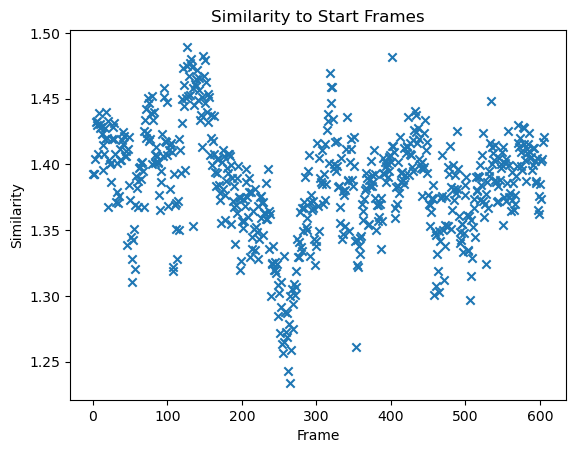

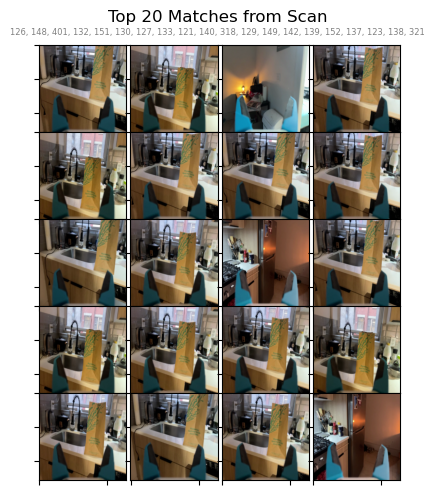

In [20]:
from pathlib import Path
import torchvision.transforms as transforms

dataset_path = 'C:/Users/clack/Datasets/Bag_Task_Data/bag_pick_up'
video_paths = [file for file in Path(dataset_path).rglob('*.mp4') if 'Depth' not in str(file.name)]
depth_paths = [next(Path(os.path.dirname(path)).rglob('*.bin')) for path in video_paths]
video_scan_path = '../scans/scan-over-bag-kitchen/rgb_frames.mp4'
depth_scan_path = '../scans/scan-over-bag-kitchen/depth_frames'

rgb_start_frames_cache_path = '../cache/bag_pickup/rgb_start_frames.pt'
depth_start_frames_cache_path = '../cache/bag_pickup/depth_start_frames.pt'
rgb_scan_frames_cache_path = '../cache/bag_pickup/rgb_scan_frames.pt'
depth_scan_frames_cache_path = '../cache/bag_pickup/depth_scan_frames.pt'

rgb_start_frames = video.load_start_frames(video_paths, cache_path=rgb_start_frames_cache_path)
rgb_scan_frames = video.load_video_frames(video_scan_path, cache_path=rgb_scan_frames_cache_path)
depth_scan_frames = video.depth_to_rgb(video.load_depth_frames_from_individual_binaries(depth_scan_path, cache_path=depth_scan_frames_cache_path), resize=(256, 256))
depth_start_frames = video.depth_to_rgb(video.load_depth_start_frames(depth_paths, cache_path=depth_start_frames_cache_path), resize=(256, 256))

rgb_alignment_scores = compute_alignment_scores(
    rgb_scan_frames.cuda(),
    rgb_start_frames.cuda(),
    encoders.resnet_encoder('cuda'),
    cosine_similarity_to_average,
    # scan_frame_encodings_cache_path='../cache/scan_frame_encodings.pt',
    # target_frame_encodings_cache_path='../cache/start_frame_encodings.pt'
)

depth_alignment_scores = compute_alignment_scores(
    depth_scan_frames.cuda(),
    depth_start_frames.cuda(),
    encoders.resnet_encoder('cuda'),
    cosine_similarity_to_average,
    # scan_frame_encodings_cache_path='../cache/scan_frame_encodings.pt',
    # target_frame_encodings_cache_path='../cache/start_frame_encodings.pt'
)
alignment_scores = [a1 + a2 for a1, a2 in zip(rgb_alignment_scores,depth_alignment_scores)]
# print(rgb_scan_frames.shape, depth_scan_frames.shape, len(alignment_scores))
visualizations.display_alignment_scores(alignment_scores)
visualizations.display_most_aligned_frames(rgb_scan_frames, alignment_scores, top_k=20)

Loading frames from ../scans/scan-over-bag-wide2.mp4: 100%|██████████| 606/606 [00:02<00:00, 284.51it/s]
Extracting start frames from dataset at ../datasets/bag_pick_up_data: 100%|██████████| 545/545 [00:03<00:00, 161.39it/s]


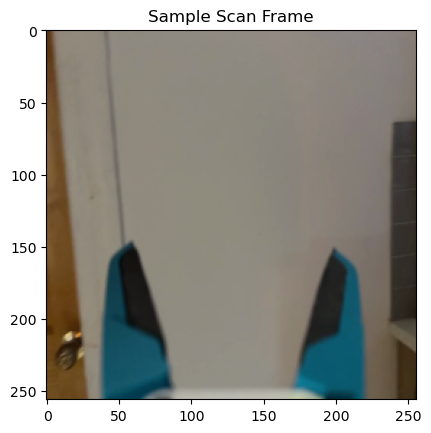

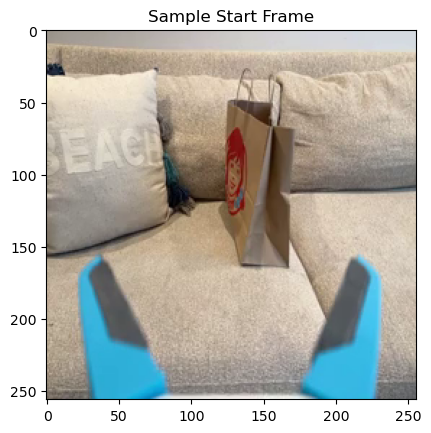

<Figure size 640x480 with 0 Axes>

In [93]:
scan_video_path = '../scans/scan-over-bag-wide2.mp4'
target_dataset_path = '../datasets/bag_pick_up_data'
# scan_video_path = '../scans/scan-over-lemon-lab.mp4'
# target_dataset_path = 'C:/Users/clack/Downloads/AnySense/lemon-pickup-short'

device = 'cuda'
scan_frames = video.load_video_frames(scan_video_path, skip_every=2).to(device)
start_frames = video.load_start_frames(target_dataset_path, transpose=False, count=2, skip_every=1).to(device)

visualizations.display_frame(scan_frames[20, :, :, :], title='Sample Scan Frame')
visualizations.display_frame(start_frames[80, :, :, :], title='Sample Start Frame')

Comparing each scan frame to start frames: 100%|██████████| 303/303 [00:04<00:00, 61.54it/s] 


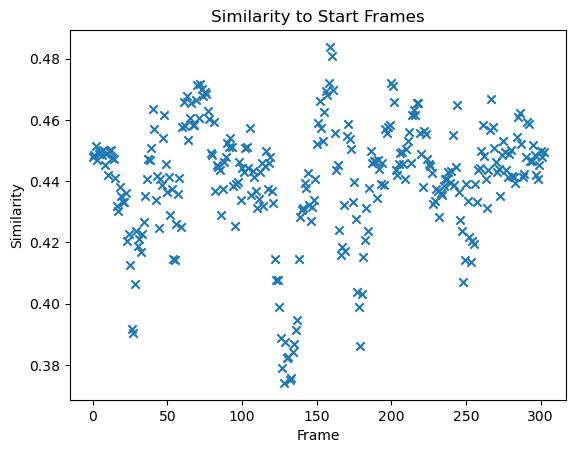

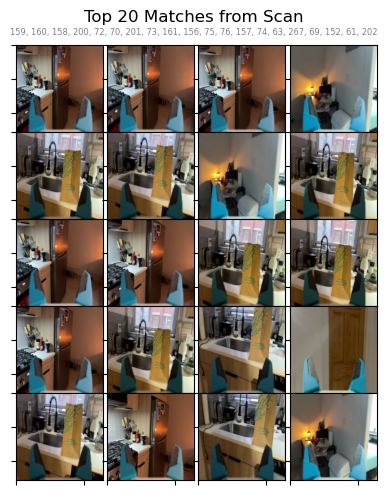

In [94]:
run_experiment(encoders.resnet_encoder(device), average_cosine_similarity)

Comparing each scan frame to start frames: 100%|██████████| 303/303 [00:04<00:00, 65.98it/s] 


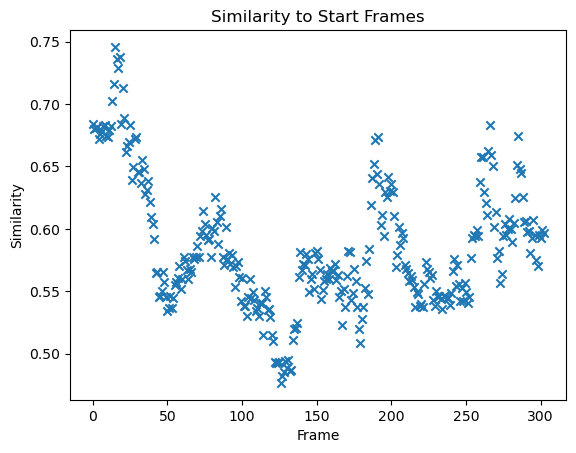

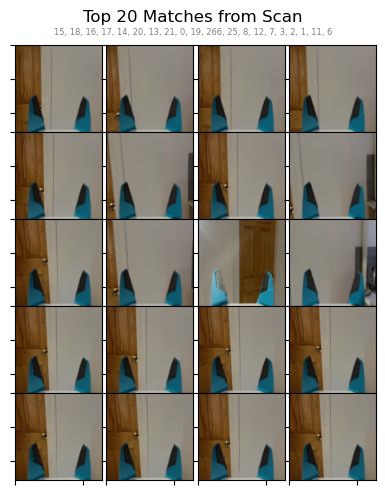

In [95]:
run_experiment(encoders.resnet_encoder(device), max_cosine_similarity)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Comparing each scan frame to start frames: 100%|██████████| 303/303 [00:23<00:00, 12.80it/s]


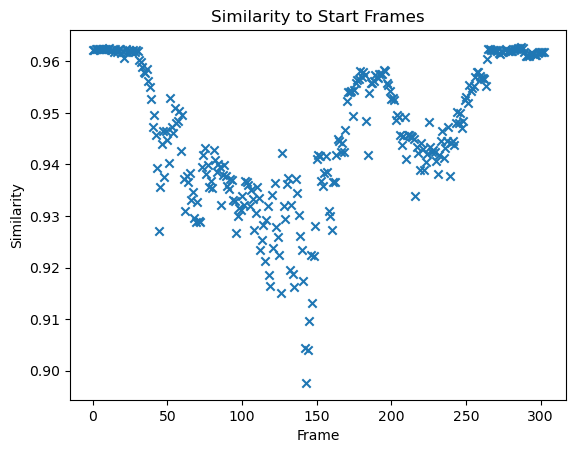

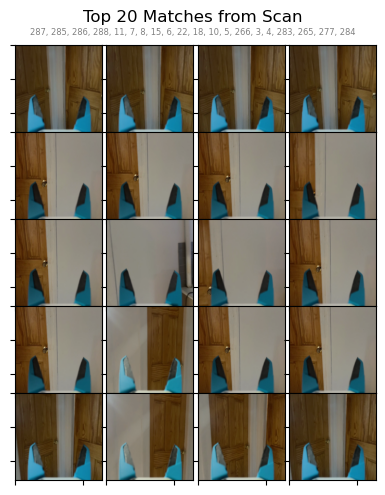

In [88]:
run_experiment(encoders.dino_hidden_state_encoder(device), average_cosine_similarity)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Comparing each scan frame to start frames: 100%|██████████| 303/303 [00:00<00:00, 5848.10it/s]


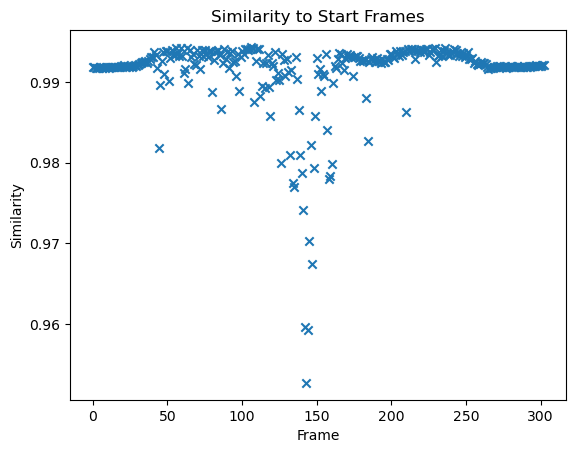

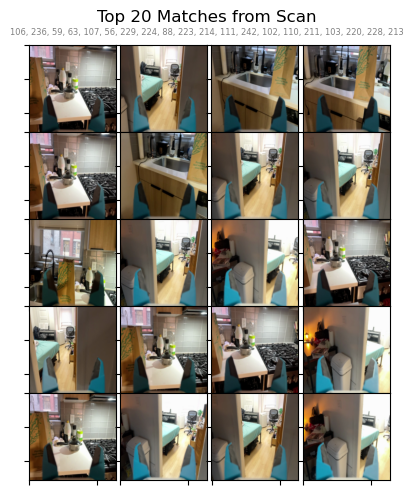

In [89]:
run_experiment(encoders.dino_cls_encoder(device), average_cosine_similarity)

Comparing each scan frame to start frames: 100%|██████████| 303/303 [00:00<00:00, 6082.16it/s]


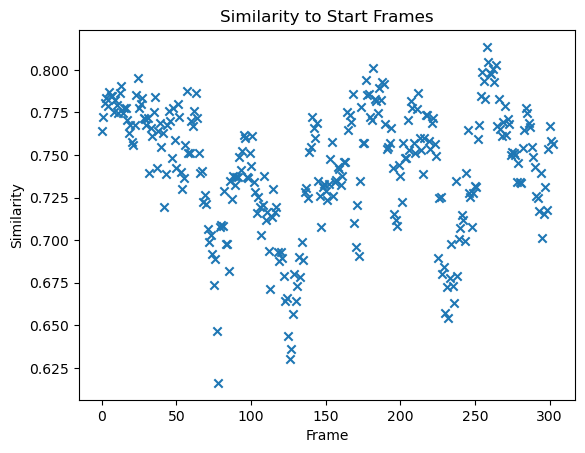

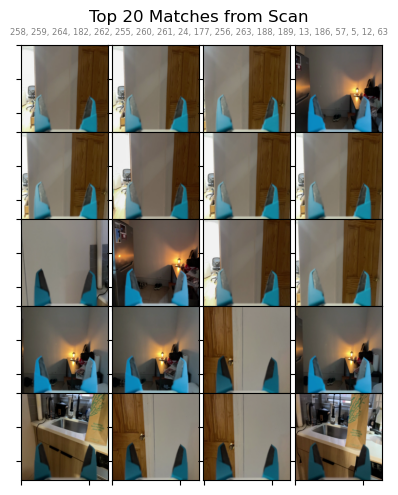

In [90]:
run_experiment(encoders.clip_encoder(device), average_cosine_similarity)

Comparing each scan frame to start frames: 100%|██████████| 111/111 [00:00<00:00, 149.75it/s]


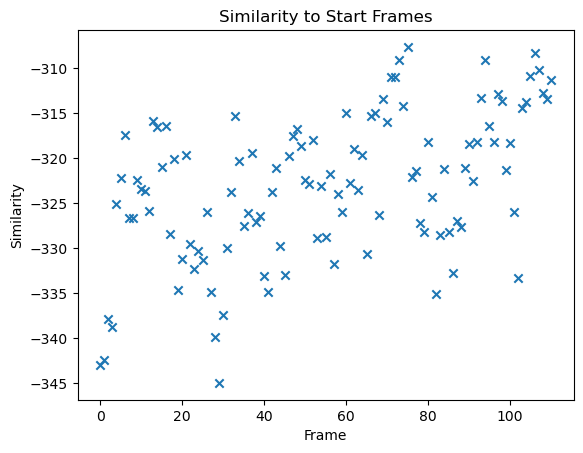

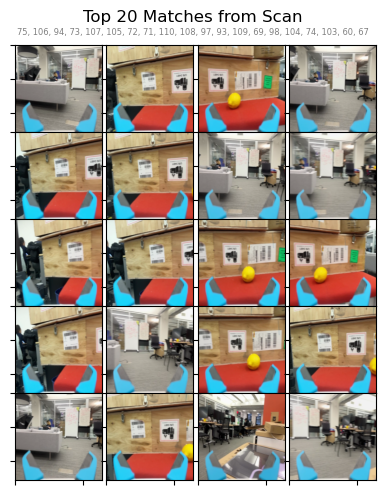

In [69]:
run_experiment(encoders.resnet_encoder(device), average_negative_squared_l2_norm)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Comparing each scan frame to start frames: 100%|██████████| 111/111 [00:00<00:00, 111.09it/s]


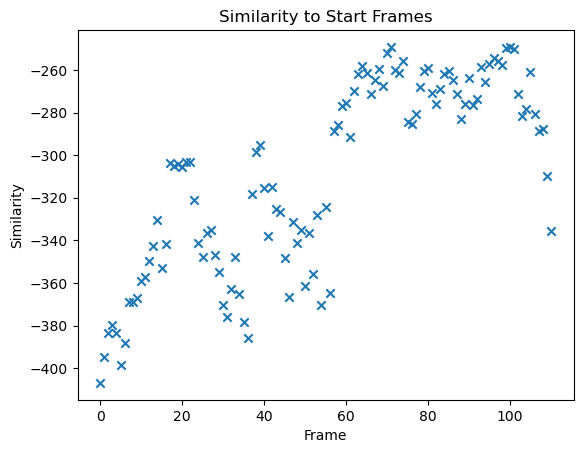

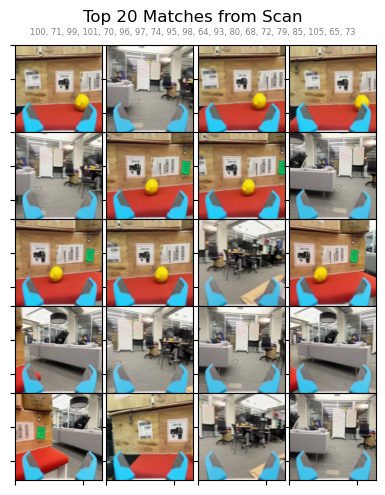

In [70]:
run_experiment(encoders.dino_hidden_state_encoder(device), average_negative_squared_l2_norm)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Comparing each scan frame to start frames: 100%|██████████| 111/111 [00:00<00:00, 1979.64it/s]


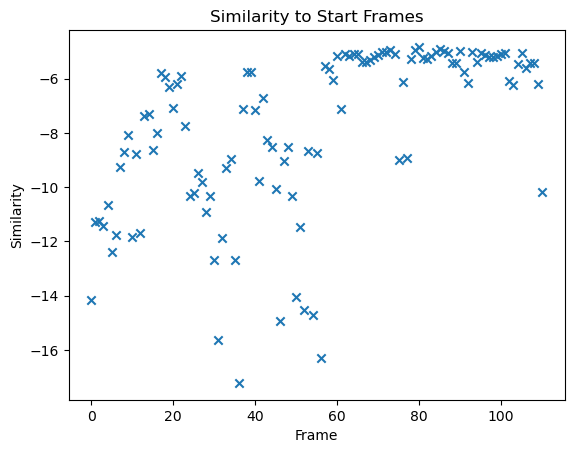

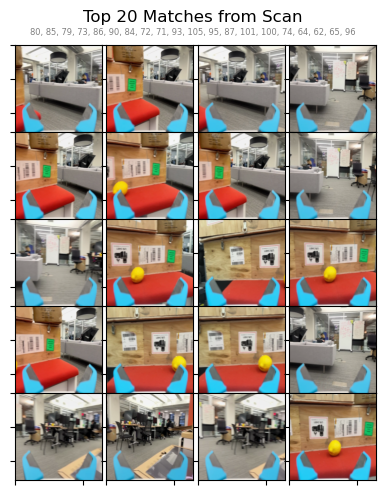

In [71]:
run_experiment(encoders.dino_cls_encoder(device), average_negative_squared_l2_norm)

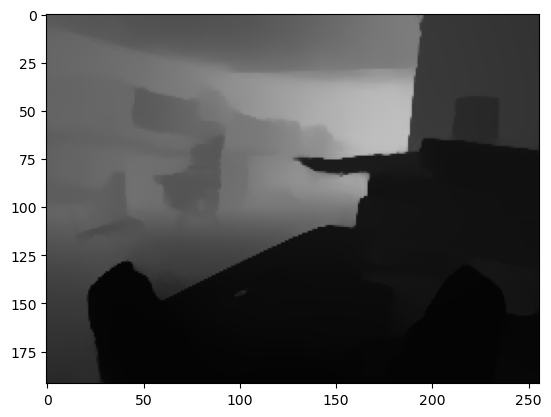

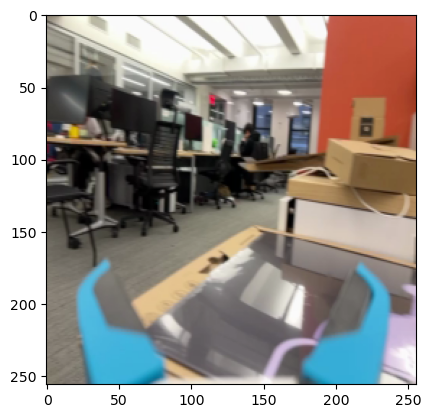

<Figure size 640x480 with 0 Axes>

In [123]:
import cv2
import numpy as np
# depth_file = 'C:/Users/clack/Downloads/AnySense/lemon-pickup-short/2025-03-13-17_33_54/Depth_Images_2025-03-13-17_33_54/0.bin'
frame = 120
depth_file = f"C:/Users\clack\Downloads\AnySense/2025-03-13-19_00_30\Depth_Images_2025-03-13-19_00_30/{frame}.bin"
# depth_file = "C:/Users\clack\Downloads\AnySense\lemon-pickup-short/2025-03-13-17_10_24\Depth_Images_2025-03-13-17_10_24/0.bin"
video_file = "C:/Users\clack\Downloads\AnySense/2025-03-13-19_00_30\RGB_2025-03-13-19_00_30.mp4"
frames = video.load_video_frames(video_file, cache_path='../cache/temp.pt')
depth_map = np.fromfile(depth_file, dtype=np.float32).reshape((192, 256))
depth_map = torch.from_numpy(depth_map).expand(3, -1, -1) / 10
# print(depth_map.min(), depth_map.max())
# print(depth_map.expand(3, -1, -1).shape, scan_frames[:, 0, :].shape)
visualizations.display_frame(depth_map)
visualizations.display_frame(frames[frame])
# cv2.imshow('Depth', depth_map)
# cv2.waitKey(0)
# cv2.destroyAllWindows()